In [217]:
from model import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import *
from sklearn.metrics import silhouette_score
import gmaps
import gmaps.datasets

In [2]:
df_commute = pd.read_csv('data/commute_data.csv')
df_tracts = pd.read_csv('data/census_tracts_2010.csv')
df_tracts = df_tracts.rename(columns=lambda x: x.strip())

# Merge on OFIPS = GEOID (federal representation of census tract ID)
df_merged = df_commute.merge(df_tracts, how='inner', left_on='OFIPS', right_on='GEOID')
df_merged = df_merged.merge(df_tracts, how='inner', left_on='DFIPS', right_on='GEOID', suffixes = ('_O','_D'))

In [178]:
df_bayarea = limit_area(df_merged, minlat=37.5, maxlat=38, minlong=-122.75, maxlong=-122.25)

In [179]:
df_state = limit_area(df_merged, state='NY', maxlat=41)

In [180]:
df_nyc = limit_area(df_merged, minlat=40.5, maxlat=41, minlong=-74.25, maxlong=-73.75)

In [181]:
df_distance_matrix = create_distance_matrix(df_bayarea, method='absolute')

In [182]:
linkage_method = 'complete'
Z = linkage(df_distance_matrix, linkage_method)

In [183]:
Z_df = pd.DataFrame(Z).astype('int')
Z_df

,0,1,2,3
0,87,88,2794,2
1,359,470,3227,3
2,58,471,4027,4
3,358,361,5123,2
4,89,472,5463,5
5,473,474,5902,7
6,360,362,6411,2
7,23,475,6640,8
8,145,149,7239,2
9,13,52,7345,2


In [246]:

k = 2
f_cluster = fcluster(Z,k,criterion='maxclust')
df_results = pd.DataFrame(index = df_distance_matrix.columns, data=f_cluster)
df_results = df_results.rename(columns={0: 'cluster_id'})
df_results = df_results.merge(df_tracts, left_index=True, right_on='GEOID')

df_results_2 = df_results.copy().reset_index()
step_0 = df_results_2.merge(Z_df, how='left', left_index=True, right_on=0).set_index(0)
step_1 = df_results_2.merge(Z_df, how='left', left_index=True, right_on=1).set_index(1)
# step_0 = step_0[3].fillna(step_1[3])
# step_0 = step_0[2].fillna(step_1[2])
df_results_2['hc_level']=step_0[3].fillna(step_1[3])
df_results_2['alpha'] = 1.5/df_results_2['hc_level']

In [247]:
df_results_2.describe()

,index,cluster_id,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,hc_level,alpha
count,470.000000,470.000000,4.700000e+02,470.000000,470.000000,4.700000e+02,4.700000e+02,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,8069.846809,1.002128,6.054158e+09,4114.312766,1807.774468,2.098356e+06,6.405336e+05,0.810198,0.247319,37.768379,-122.389333,4.153191,0.644504
std,2799.615984,0.046127,3.253228e+07,1636.904805,750.789467,7.663399e+06,5.903476e+06,2.958865,2.279323,0.117362,0.085341,22.373976,0.177562
min,3562.000000,1.000000,6.001400e+09,38.000000,14.000000,5.656400e+04,0.000000e+00,0.022000,0.000000,37.503768,-122.676117,2.000000,0.003191
25%,4185.250000,1.000000,6.013379e+09,3019.000000,1302.500000,3.989338e+05,0.000000e+00,0.154000,0.000000,37.715022,-122.450896,2.000000,0.500000
50%,9912.500000,1.000000,6.075018e+09,4014.000000,1773.500000,7.705920e+05,0.000000e+00,0.298000,0.000000,37.776417,-122.410735,2.000000,0.750000
75%,10029.750000,1.000000,6.075061e+09,5073.500000,2267.000000,1.420017e+06,0.000000e+00,0.548500,0.000000,37.844742,-122.302810,3.000000,0.750000
max,10391.000000,2.000000,6.081614e+09,11502.000000,8255.000000,1.280043e+08,1.238387e+08,49.423000,47.814000,37.998899,-122.251038,470.000000,0.750000


In [248]:
cluster_order = list(df_results_2.groupby('cluster_id').count().sort_values('GEOID', ascending=False).index)

In [249]:
from matplotlib import cm
colors = []
for i, val in enumerate(cluster_order):
    (r, g, b, a) = cm.Dark2(i%8)
    colors.append([val,r, g, b])

#colors = np.array(colors)
colors = pd.DataFrame(colors, columns=['cluster_id','r','g','b'])

In [250]:
#color_array = np.array(df_results_2[['r', 'g', 'b', 'alpha']])

In [251]:
df_results_2 = df_results_2.merge(colors, on='cluster_id')

In [252]:
color_array = []
for i, row in df_results_2.iterrows():
    r, g, b, a = row['r'], row['g'], row['b'], row['alpha']
    color_array.append([r, g, b, a])

In [253]:
#def rgba(row):
#    row['rgba'] =list([row['color'][0],row['color'][1],row['color'][2],row['alpha']])
#    return row
#df_color = df_results_2.apply(rgba,axis=1)

In [254]:
#rgba_color = np.array(df_color['rgba'].values)

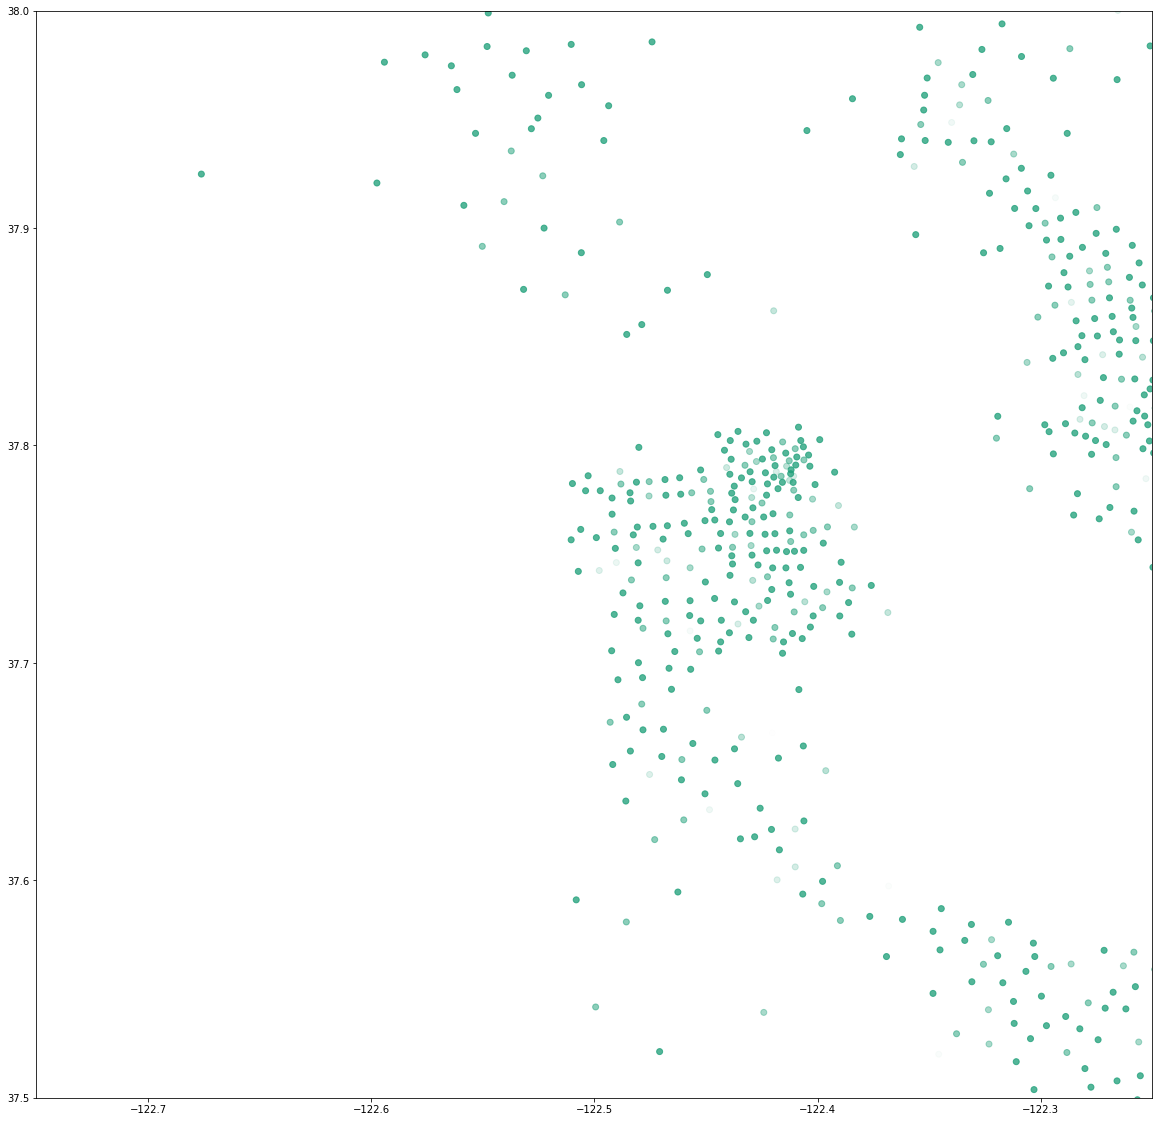

In [255]:
plt.figure(figsize=(20,20))
plt.scatter(df_color['INTPTLONG'],df_color['INTPTLAT'], color=color_array)
#plt.ylim(36,38.5)
#plt.xlim(-123,-120.5)
plt.ylim(37.5,38)
plt.xlim(-122.75,-122.25)
plt.show()

In [256]:
#distmatrix1 = scipy.spatial.distance.squareform(distmatrix + distmatrix.T)
#df_distance_matrix
##ddgm = scipy.cluster.hierarchy.linkage(distmatrix1, method="average")
#Z
#nodes = scipy.cluster.hierarchy.fcluster(ddgm, 4, criterion="maxclust")
#f_cluster
silhouette_score(df_distance_matrix , f_cluster, metric='precomputed')

0.020918981649732726

In [257]:
# Use google maps api
gmaps.configure(api_key=api_key) # Fill in with your API key

#Set up your map
fig = gmaps.figure()
colors = list(df_results['color'].values)
locations = list(zip(df_results['INTPTLAT'],df_results['INTPTLONG']))
symbols = gmaps.symbol_layer(
        locations,
        fill_color=colors,
        stroke_color=colors,
        scale=2)
fig.add_layer(symbols)
fig

NameError: name 'api_key' is not defined